In [1]:
import numpy as np
import pandas as pd
from yahooquery import Ticker

In [31]:
%matplotlib inline

In [2]:
class BayesTable:
    def __init__(self, lambdas, prior, num_evidences):
        self.df = self._make_df(lambdas, prior, num_evidences)
    
    def _column_names(self, num_evidences, row_len):
        cols = []
        max_val = row_len / num_evidences
        cur_evidence = 0
        sub = 0
        for i in range(row_len):
            cols.append(f'e{cur_evidence + 1}{sub + 1}')
            sub += 1
            if sub == max_val:
                cur_evidence += 1
                sub = 0

        return cols
    
    def _make_df(self, lambdas, prior, num_evidences):
        df = pd.DataFrame(lambdas, index=[f'H{i+1}' for i in range(len(prior))])
        df.columns = self._column_names(num_evidences, len(df.columns))
        df['prior'] = prior
        return df

    def __repr__(self):
        return repr(self.df)
    
    def __call__(self):
        return self.df
    
    def evidence(self, e):
        df = self.df.copy()
        unnorm = df[e] * df['prior']
        df['updated'] = unnorm / unnorm.sum()
        return df
    
    def evidences(self, e_list):
        original_df = self.df.copy()
        for e in e_list:
            df = self.evidence(e)
            df = df.drop(['prior'], axis=1).rename({'updated': 'prior'}, axis=1)
            self.df = df
        
        r = self.df.rename({'prior': 'final'}, axis=1)
        self.df = original_df
        return r

In [3]:
table = BayesTable([
    [0.50, 0.40, 0.10, 0.50, 0.40, 0.10],
    [0.06, 0.50, 0.44, 0.06, 0.50, 0.44],
    [0.50, 0.10, 0.40, 0.50, 0.10, 0.40],
    [1.00, 0.00, 0.00, 1.00, 0.00, 0.00]
], [0.099, 0.0099, 0.0001, 0.891], 2)

In [4]:
table()

,e11,e12,e13,e21,e22,e23,prior
H1,0.50,0.4,0.10,0.50,0.4,0.10,0.0990
H2,0.06,0.5,0.44,0.06,0.5,0.44,0.0099
H3,0.50,0.1,0.40,0.50,0.1,0.40,0.0001
H4,1.00,0.0,0.00,1.00,0.0,0.00,0.8910


In [5]:
table.evidence('e13')

,e11,e12,e13,e21,e22,e23,prior,updated
H1,0.50,0.4,0.10,0.50,0.4,0.10,0.0990,0.692501
H2,0.06,0.5,0.44,0.06,0.5,0.44,0.0099,0.304701
H3,0.50,0.1,0.40,0.50,0.1,0.40,0.0001,0.002798
H4,1.00,0.0,0.00,1.00,0.0,0.00,0.8910,0.000000


In [6]:
table.evidences(['e13', 'e21'])

,e11,e12,e13,e21,e22,e23,final
H1,0.50,0.4,0.10,0.50,0.4,0.10,0.946217
H2,0.06,0.5,0.44,0.06,0.5,0.44,0.049960
H3,0.50,0.1,0.40,0.50,0.1,0.40,0.003823
H4,1.00,0.0,0.00,1.00,0.0,0.00,0.000000


---

In [94]:
df = Ticker(['^BVSP', 'abev']).history('3y', adj_ohlc=True)
df = df[['close']].reset_index().pivot('date', 'symbol', 'close')
df = df.dropna().rename({'^BVSP': 'ibov'}, axis=1)
df

symbol,ibov,abev
date,,
2019-05-13,91727.0,3.899732
2019-05-14,92092.0,3.881552
2019-05-15,91623.0,3.763378
2019-05-16,90024.0,3.763378
2019-05-17,89993.0,3.681565
...,...,...
2022-05-05,105304.0,2.710000
2022-05-06,105135.0,2.620000
2022-05-09,103250.0,2.610000


<AxesSubplot:xlabel='date'>

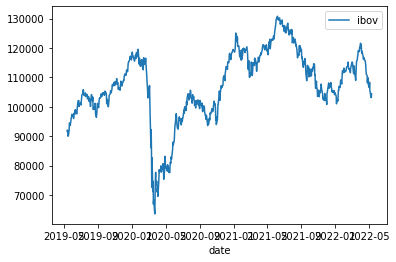

In [95]:
df.plot(y='ibov')

<AxesSubplot:xlabel='date'>

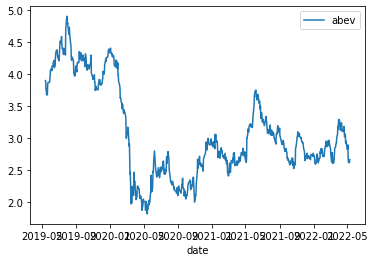

In [96]:
df.plot(y='abev')

In [97]:
df = df.join(df[['ibov', 'abev']].rolling(50).mean().rename({'ibov': 'ibov_long_ma', 'abev': 'abev_long_ma'}, axis=1))
df = df.join(df[['ibov', 'abev']].rolling(20).mean().rename({'ibov': 'ibov_short_ma', 'abev': 'abev_short_ma'}, axis=1))
df = df.dropna()

In [98]:
df

symbol,ibov,abev,ibov_long_ma,abev_long_ma,ibov_short_ma,abev_short_ma
date,,,,,,
2019-07-25,102655.0,4.690587,99072.16,4.172804,103194.35,4.382881
2019-07-26,102819.0,4.763309,99294.00,4.190076,103300.85,4.407425
2019-07-29,103483.0,4.908754,99521.82,4.210620,103438.80,4.438786
2019-07-30,102933.0,4.836032,99748.02,4.232073,103537.10,4.468329
2019-07-31,101812.0,4.790580,99983.78,4.252617,103560.70,4.497418
...,...,...,...,...,...,...
2022-05-05,105304.0,2.710000,114158.74,2.946800,112524.95,3.027000
2022-05-06,105135.0,2.620000,114006.08,2.941600,111870.30,3.001000
2022-05-09,103250.0,2.610000,113813.24,2.936000,111089.70,2.974500


In [99]:
for key in ['ibov', 'abev']:
    df[f'{key}_ma_return'] = df[f'{key}_short_ma'] / df[f'{key}_long_ma'] - 1
    df[f'{key}_trend'] = df[f'{key}_ma_return'].map(lambda v: -1 if v < -0.03 else 1 if v > 0.03 else 0)

In [100]:
df['return'] = df['abev'].shift(-3) / df['abev'] - 1
df['y'] = df[f'return'].map(lambda v: -1 if v < -0.01 else 1 if v > 0.01 else 0)
df = df.dropna()

In [103]:
df

symbol,ibov,abev,ibov_long_ma,abev_long_ma,ibov_short_ma,abev_short_ma,ibov_ma_return,ibov_trend,abev_ma_return,abev_trend,return,y
date,,,,,,,,,,,,
2019-07-25,102655.0,4.690587,99072.16,4.172804,103194.35,4.382881,0.041608,1,0.050344,1,0.031008,1
2019-07-26,102819.0,4.763309,99294.00,4.190076,103300.85,4.407425,0.040353,1,0.051872,1,0.005725,0
2019-07-29,103483.0,4.908754,99521.82,4.210620,103438.80,4.438786,0.039358,1,0.054188,1,-0.020370,-1
2019-07-30,102933.0,4.836032,99748.02,4.232073,103537.10,4.468329,0.037987,1,0.055825,1,-0.015038,-1
2019-07-31,101812.0,4.790580,99983.78,4.252617,103560.70,4.497418,0.035775,1,0.057565,1,-0.034156,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,106639.0,2.820000,114622.60,2.953200,114602.90,3.094000,-0.000172,0,0.047677,1,-0.039007,-1
2022-05-03,106528.0,2.830000,114459.96,2.950800,113850.80,3.071000,-0.005322,0,0.040735,1,-0.074205,-1
2022-05-04,108344.0,2.890000,114323.22,2.949800,113204.00,3.051500,-0.009790,0,0.034477,1,-0.096886,-1


In [108]:
def p(df, col, v, y):
    return len(df[(df[col] == v) & (df['y'] == y)]) / len(df[df['y'] == y])

In [118]:
def lambdas_for_h(h):
    return [
        p(df, 'abev_trend', -1, h),
        p(df, 'abev_trend', 0, h),
        p(df, 'abev_trend', 1, h),
        p(df, 'ibov_trend', -1, h),
        p(df, 'ibov_trend', 0, h),
        p(df, 'ibov_trend', 1, h)
    ]

In [119]:
lambdas = [
    lambdas_for_h(-1),
    lambdas_for_h(0),
    lambdas_for_h(1)
]

In [124]:
def prior(df, h):
    return len(df[df['y'] == h]) / len(df)

In [125]:
priors = [prior(df, i) for i in [-1, 0, 1]]

In [127]:
table = BayesTable(lambdas, priors, 2)
table()

,e11,e12,e13,e21,e22,e23,prior
H1,0.331010,0.320557,0.348432,0.219512,0.498258,0.282230,0.424556
H2,0.302013,0.402685,0.295302,0.120805,0.664430,0.214765,0.220414
H3,0.391667,0.358333,0.250000,0.104167,0.666667,0.229167,0.355030


In [128]:
table.evidences(['e11', 'e23'])

,e11,e12,e13,e21,e22,e23,final
H1,0.331010,0.320557,0.348432,0.219512,0.498258,0.282230,0.462130
H2,0.302013,0.402685,0.295302,0.120805,0.664430,0.214765,0.166577
H3,0.391667,0.358333,0.250000,0.104167,0.666667,0.229167,0.371293


In [129]:
table.evidences(['e12', 'e22'])

,e11,e12,e13,e21,e22,e23,final
H1,0.331010,0.320557,0.348432,0.219512,0.498258,0.282230,0.320470
H2,0.302013,0.402685,0.295302,0.120805,0.664430,0.214765,0.278706
H3,0.391667,0.358333,0.250000,0.104167,0.666667,0.229167,0.400824


In [130]:
table.evidences(['e13', 'e23'])

,e11,e12,e13,e21,e22,e23,final
H1,0.331010,0.320557,0.348432,0.219512,0.498258,0.282230,0.548844
H2,0.302013,0.402685,0.295302,0.120805,0.664430,0.214765,0.183765
H3,0.391667,0.358333,0.250000,0.104167,0.666667,0.229167,0.267392
